In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import mlflow

In [3]:
# Data Augmentation
image_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((256,256), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(image_dir))


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [5]:
dataset = SegmentationDataset(
    image_dir = "Data/images",
    mask_dir = "Data/masks",
    image_transform = image_transform,
    mask_transform = mask_transform
)

In [6]:
dataset_size = len(dataset)

train_size = int(0.70 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - (train_size + val_size)

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [7]:
#Building block of the Double convolution of U net

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [8]:
## Unet

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.down1 = DoubleConv(3,64)
        self.pool1 = nn.MaxPool2d(2)
    
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
    
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
    
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
    
        self.bottleneck = DoubleConv(512, 1024)
    
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
    
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
    
        self.up2 = nn.ConvTranspose2d(256,128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
    
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)
    
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self,x):
        c1 = self.down1(x)
        p1 = self.pool1(c1)

        c2 = self.down2(p1)
        p2 = self.pool2(c2)

        c3 = self.down3(p2)
        p3 = self.pool3(c3)

        c4 = self.down4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        u4 = self.up4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        u4 = self.conv4(u4)

        u3 = self.up3(u4)
        u3 = torch.cat([u3, c3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, c2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, c1], dim=1)
        u1 = self.conv1(u1)

        return torch.sigmoid(self.final(u1))

In [9]:
## Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# mlflow.set_tracking_uri("file:///kaggle/working/mlruns")
mlflow.set_experiment("tumor segmentation with UNet")

params = {
    "epochs": 50,
    "learning_rate":1e-4,
    "batch_size":8
}

best_model_dir = "model"

2026/01/08 17:39:07 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/08 17:39:07 INFO mlflow.store.db.utils: Updating database tables
2026/01/08 17:39:07 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/08 17:39:07 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/08 17:39:07 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/08 17:39:07 INFO alembic.runtime.migration: Will assume non-transactional DDL.


In [10]:
## Accuracy models

def dice_score(preds, targets, smooth=1e-6):
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def pixel_accuracy(preds, targets):
    preds = (preds > 0.5).float()
    correct = (preds == targets).sum()
    total = targets.numel()
    return correct / total

def iou_score(preds, targets, smooth=1e-6):
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)

In [15]:
## Training loop function
# def train_model(train_loader, val_loader, criterion, optimizer):

with mlflow.start_run():

    mlflow.log_params(params)
    
    model = UNet().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
    
    train_dice, val_dice, train_loss, val_loss = [],[],[],[]
    best_val_dice = 0.0
    
    for epoch in range(params["epochs"]):
        model.train()
        running_loss = 0.0
        running_dice = 0.0
        num_batches = 0
    
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
    
            optimizer.zero_grad()
            outputs = model(imgs)
    
            #Back propergation
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            running_dice += dice_score(outputs, masks).item()
            num_batches += 1
    
        epoch_train_loss = running_loss/num_batches
        epoch_train_dice = running_dice/num_batches
    
        train_loss.append(epoch_train_loss)
        train_dice.append(epoch_train_dice)
    
        model.eval()
        running_loss = 0.0
        running_dice = 0.0
        num_batches = 0
    
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
    
                loss = criterion(outputs, masks)
                running_loss += loss.item()
    
                running_dice += dice_score(outputs, masks).item()
                num_batches += 1
    
        epoch_val_loss = running_loss/num_batches
        epoch_val_dice = running_dice/num_batches
    
        val_loss.append(epoch_val_loss)
        val_dice.append(epoch_val_dice)
    
        ## saving the best model
        if epoch_val_dice > best_val_dice:
            best_val_dice = epoch_val_dice
            torch.save(model.state_dict(),os.path.join(best_model_dir, "best_model.pth"))
    
        print(f"Epoch [{epoch+1}/{params["epochs"]}], Tr dice: {100*epoch_train_dice:.2f}%, Val dice: {100*epoch_val_dice:.2f}%, Best Val Acc: {100*best_val_dice:.2f}%")
        mlflow.log_metrics({
            "training_loss":epoch_train_loss,
            "training_dice":epoch_train_dice,
            "validation_loss":epoch_val_loss,
            "validation_dice":epoch_val_dice
        }, step=epoch)
    
    print("Training Complete")
    mlflow.pytorch.log_model(model, artifact_path="model")

Epoch [1/50], Tr dice: 0.00%, Val dice: 0.00%, Best Val Acc: 0.00%
Epoch [2/50], Tr dice: 0.00%, Val dice: 0.00%, Best Val Acc: 0.00%
Epoch [3/50], Tr dice: 2.04%, Val dice: 11.98%, Best Val Acc: 11.98%
Epoch [4/50], Tr dice: 17.31%, Val dice: 10.11%, Best Val Acc: 11.98%
Epoch [5/50], Tr dice: 24.89%, Val dice: 33.83%, Best Val Acc: 33.83%
Epoch [6/50], Tr dice: 37.11%, Val dice: 42.68%, Best Val Acc: 42.68%
Epoch [7/50], Tr dice: 43.70%, Val dice: 50.27%, Best Val Acc: 50.27%
Epoch [8/50], Tr dice: 49.35%, Val dice: 44.19%, Best Val Acc: 50.27%
Epoch [9/50], Tr dice: 55.09%, Val dice: 56.83%, Best Val Acc: 56.83%
Epoch [10/50], Tr dice: 59.56%, Val dice: 59.01%, Best Val Acc: 59.01%
Epoch [11/50], Tr dice: 63.48%, Val dice: 56.76%, Best Val Acc: 59.01%
Epoch [12/50], Tr dice: 66.59%, Val dice: 61.31%, Best Val Acc: 61.31%
Epoch [13/50], Tr dice: 69.14%, Val dice: 68.32%, Best Val Acc: 68.32%
Epoch [14/50], Tr dice: 72.84%, Val dice: 68.20%, Best Val Acc: 68.32%
Epoch [15/50], Tr dice

2026/01/07 20:30:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [50/50], Tr dice: 96.99%, Val dice: 81.59%, Best Val Acc: 81.59%
Training Complete


2026/01/07 20:30:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.1+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/01/07 20:31:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.1+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [12]:
# Testing and inference the model
criterion = nn.BCELoss()
model = UNet().to(device)
model.load_state_dict(torch.load(os.path.join(best_model_dir, "best_model.pth")))
model.eval()
with torch.no_grad():
    running_loss = 0.0
    running_dice = 0.0
    num_batches = 0

    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)

        loss = criterion(outputs, masks)
        running_loss += loss.item()

        running_dice += dice_score(outputs, masks).item()
        num_batches += 1
    
    test_loss = running_loss/num_batches
    test_dice = running_dice/num_batches

    print(f"Test Loss: {test_loss:.4f}, Test Dice Score: {100*test_dice:.2f}%")
    

Test Loss: 0.0137, Test Dice Score: 92.86%


In [15]:
# ploting segementation results
def plot_segmentation_results(model, dataset, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    
    with torch.no_grad():
        for i in range(num_samples):
            image, mask = dataset[i]
            input_img = image.unsqueeze(0).to(device)
            output = model(input_img)
            output_mask = (output.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
            
            axes[i, 0].imshow(image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
            axes[i, 1].set_title("Ground Truth Mask")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(output_mask, cmap='gray')
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

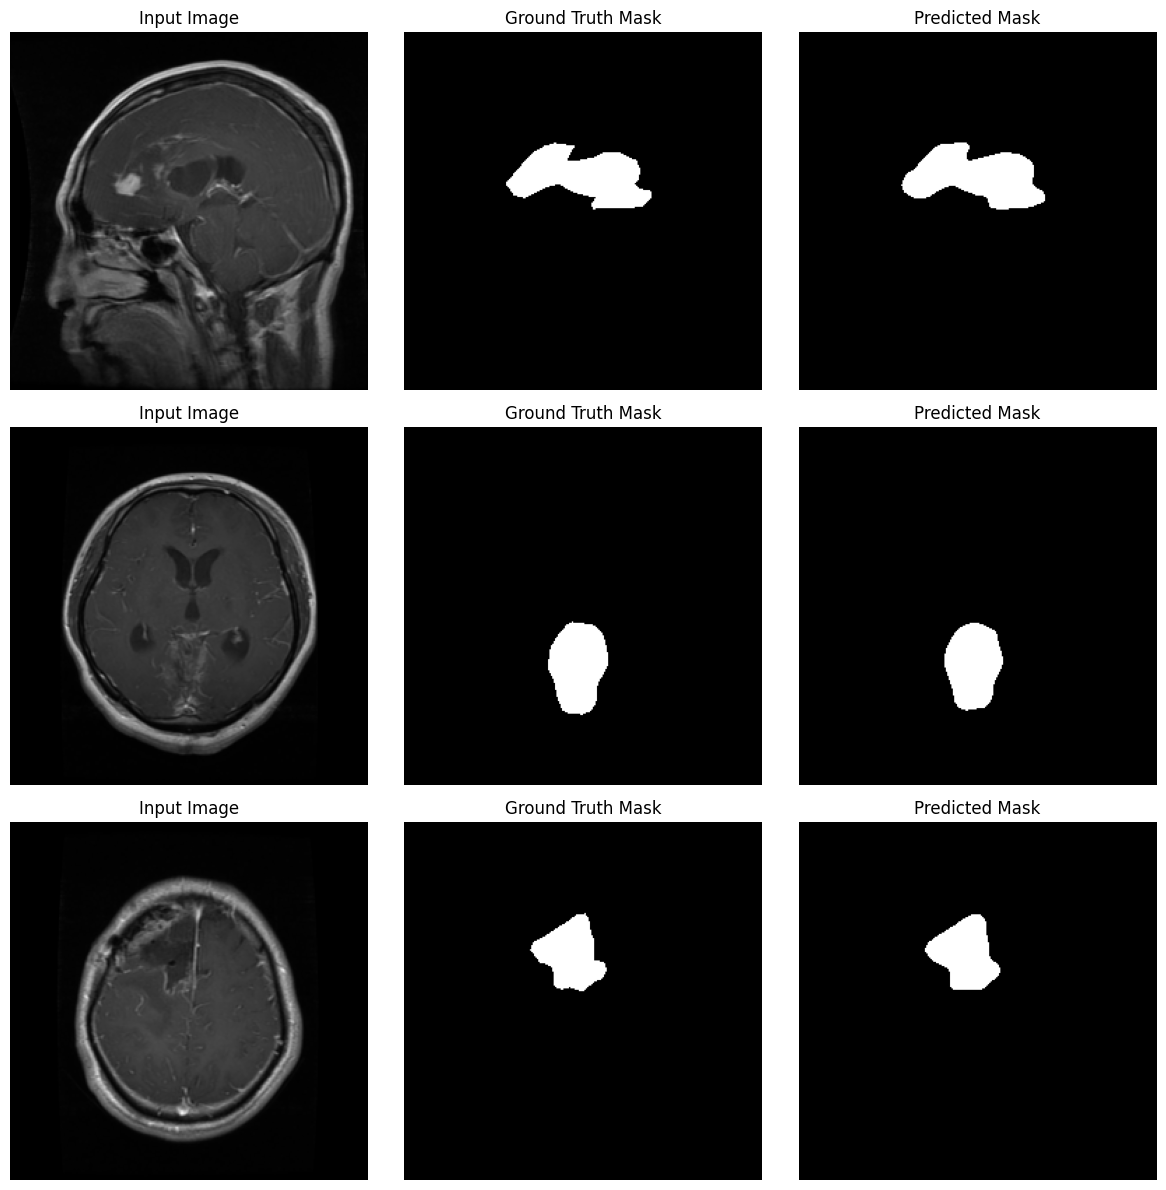

In [16]:
plot_segmentation_results(model, test_dataset, num_samples=3)

In [17]:
# Testing for a unknown image
def predict_mask(model, image, transform=None):
    model.eval()
    if transform:
        image = transform(image)
    input_img = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_img)
        output_mask = (output.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    
    return output_mask


In [18]:
def plot_prediction(image, predicted_mask):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[0].set_title("Input Image")
    axes[0].axis('off')
    
    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

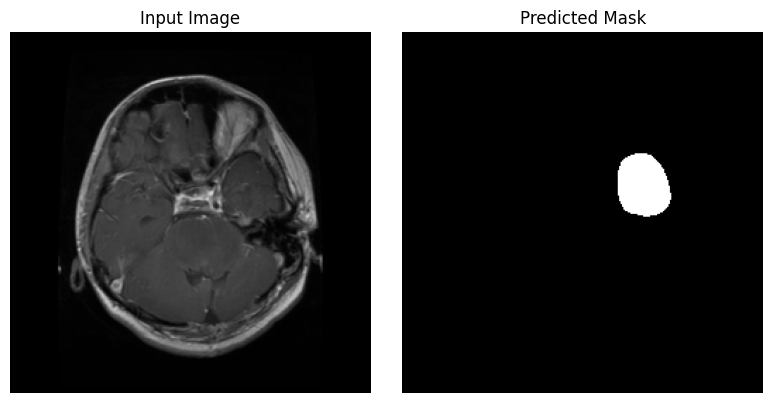

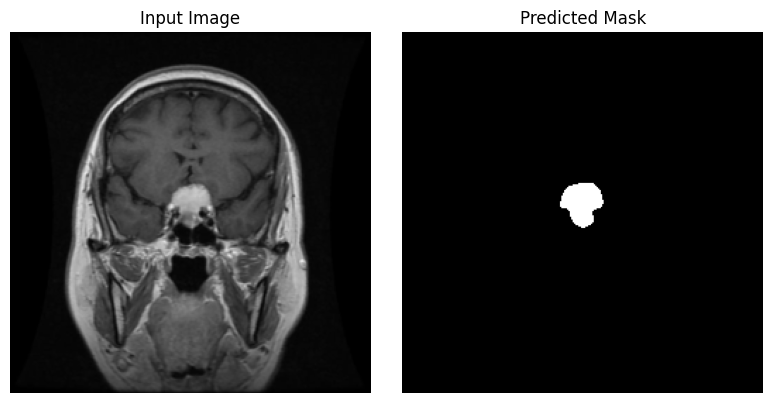

In [19]:
img_1 = "Test/Te-gl_0010.jpg"
img_2 = "Test/Te-piTr_0002.jpg"

for img_path in [img_1, img_2]:
    image = Image.open(img_path).convert("RGB")
    predicted_mask = predict_mask(model, image, transform=image_transform)
    input_image = image_transform(image)
    plot_prediction(input_image, predicted_mask)